In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
sys.path.insert(0, str(Path.cwd().parent))
import scripts.eda_toolkit as eda
import mlflow
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders import OneHotEncoder, WOEEncoder, CountEncoder, TargetEncoder, CatBoostEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, precision_score

In [2]:
RANDOM_STATE = 8
CV = 10

home = Path.cwd().parent
data_dir = home / "data"
notebook_dir = home / "notebooks"
df = pd.read_csv(data_dir / "processed" / "german_credit.csv")
sklearn.set_config(transform_output="pandas")

In [3]:

X_temp, X_test, y_temp, y_test = train_test_split(
    df.drop(columns=["class"]),
    df["class"],
    test_size=0.15,
    random_state=RANDOM_STATE,
    stratify=df["class"]
)

X_temp.shape, y_temp.shape

((850, 20), (850,))

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=len(X_test),
    random_state=RANDOM_STATE,
    stratify=y_temp
) 
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((700, 20), (700,), (150, 20), (150,))

In [5]:
train_df = X_train.copy()
train_df.shape

(700, 20)

In [6]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Custom transformer for creating new features and transforming existing ones."""

    def __init__(self, duplicate_checking=False):
        self.cols_to_drop = [
            "other_debtors_guarantors",
            "telephone",
            "foreign_worker",
            "present_residence_since",
            "existing_credits_count",
            "people_liable_for_maintenance",
            "installment_rate_pct_of_disp_income",
            "personal_status_sex",
        ]
        self.duplicate_checking = duplicate_checking
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Drop unnecessary columns first (only if they exist)
        cols_to_drop_existing = [c for c in self.cols_to_drop if c in X.columns]
        X = X.drop(columns=cols_to_drop_existing)
        
        if self.duplicate_checking:
            X['checking_2'] = X['checking_account_status'].copy()
            X['checking_3'] = X['checking_account_status'].copy()

        # Create new features (before dropping the source columns)
        X['monthly_burden'] = X['credit_amount'] / X['duration_months']
        X['monthly_burden_log'] = np.log(X['monthly_burden'])
        
        # Create duration bins BEFORE dropping duration_months
        X['duration_bins'] = pd.qcut(X['duration_months'], q=5, labels=['very_short', 'short', 'medium', 'long', 'very_long'])
        
        # Merge purpose categories
        X['purpose'] = X['purpose'].replace(
            ['education', 'retraining'], 'personal_development'
        )
        X['purpose'] = X['purpose'].replace(
            ['domestic appliances', 'repairs', 'others'], 'home_improvement'
        )
        
        # Bin credit amount
        X['credit_amount_bins'] = pd.cut(
            X['credit_amount'],
            bins=[0, 2000, 4000, 7000, 10000, 50000],
            labels=['a', 'b', 'c', 'd', 'e']
        )
        
        # Merge savings categories
        X['savings_account_bonds'] = X['savings_account_bonds'].replace(
            ['< 100 DM', '100 <= ... < 500 DM'], '< 500 DM'
        )
        X['savings_account_bonds'] = X['savings_account_bonds'].replace(
            ['500 <= ... < 1000 DM', '>= 1000 DM'], '>= 500 DM'
        )
        
        # Create age groups BEFORE dropping age_years
        X['age_group'] = pd.cut(
            X['age_years'],
            bins=[0, 25, 35, 55, 100],
            labels=['Young', 'Early_Career', 'Prime', 'Mature']
        )
        
        # Merge housing categories
        X['housing'] = X['housing'].replace(['for free', 'rent'], 'not_own')

        # Merge credit history categories
        X['credit_history'] = X['credit_history'].replace(
            ['all credits here paid duly', 'no credits/all paid duly'], 'all credits paid'
        )
        
        # Drop original columns that were transformed (AFTER creating derived features)
        X = X.drop(columns=['duration_months', 'credit_amount', 'age_years', 'monthly_burden'])

        return X


In [7]:
train_df = FeatureEngineer().transform(train_df)
val_df = FeatureEngineer().transform(X_val)

In [8]:
train_df.columns, val_df.columns

(Index(['checking_account_status', 'credit_history', 'purpose',
        'savings_account_bonds', 'present_employment_since', 'property',
        'other_installment_plans', 'housing', 'job', 'monthly_burden_log',
        'duration_bins', 'credit_amount_bins', 'age_group'],
       dtype='object'),
 Index(['checking_account_status', 'credit_history', 'purpose',
        'savings_account_bonds', 'present_employment_since', 'property',
        'other_installment_plans', 'housing', 'job', 'monthly_burden_log',
        'duration_bins', 'credit_amount_bins', 'age_group'],
       dtype='object'))

In [8]:
# Define column groups for encoding (output columns from FeatureEngineer)
one_hot_cols_svc = [
    'purpose',
    'savings_account_bonds',
    'job'
]

woe_cols_svc = [
    'present_employment_since',
    'duration_bins'
]

target_cols_svc = [
    'checking_account_status',
    'credit_history',
    #'housing'
]

count_cols_svc = [
    'property',
    'other_installment_plans',
    'housing',
    'credit_amount_bins',
    'age_group'
]

one_hot_cols_lrc = [
    'purpose',
    'job'
]

woe_cols_lrc = [
    'checking_account_status',
    'credit_history',
    'savings_account_bonds',
    'present_employment_since',
    'housing',
    'duration_bins'
]

count_cols_lrc = [
    'property',
    'other_installment_plans',
    'credit_amount_bins',
    'age_group'
]

one_hot_rfc = [
    'checking_account_status', 
    'credit_history', 
    'savings_account_bonds',  
    'property', 
    'housing',  
    'duration_bins', 
    'credit_amount_bins', 

]

count_cols_rfc = [
    'checking_2',
    'present_employment_since',
    'other_installment_plans',
    'job',
    'age_group'
]

target_cols_rfc = [
    'checking_3',
    'purpose'
]

numeric_cols = [
    'monthly_burden_log',
]

### svc

In [9]:
# Create the encoding pipeline
encoding_pipeline_svc = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(cols=one_hot_cols_svc, use_cat_names=True), one_hot_cols_svc),
        ('woe', WOEEncoder(cols=woe_cols_svc), woe_cols_svc),
        ('scaler', StandardScaler(), numeric_cols),
        ('count', CountEncoder(cols=count_cols_svc, normalize=True), count_cols_svc),
        ('target', TargetEncoder(cols=target_cols_svc, smoothing=5), target_cols_svc)
    ],
    remainder='drop'  # or 'passthrough' if you want to keep other columns
)


# Full pipeline combining feature engineering + encoding
full_pipeline_svc = Pipeline([
    ('feature_engineer', FeatureEngineer()),
    ('encoder', encoding_pipeline_svc)
])

### logreg

In [14]:
encoding_pipeline_lrc = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(cols=one_hot_cols_lrc, use_cat_names=True), one_hot_cols_lrc),
        ('woe', WOEEncoder(cols=woe_cols_lrc), woe_cols_lrc),
        ('scaler', StandardScaler(), numeric_cols),
        ('count', CountEncoder(cols=count_cols_lrc, normalize=True), count_cols_lrc),
    ],
    remainder='drop'  # or 'passthrough' if you want to keep other columns
)

# Full pipeline combining feature engineering + encoding
full_pipeline_lrc = Pipeline([
    ('feature_engineer', FeatureEngineer()),
    ('encoder', encoding_pipeline_lrc)
])

### random forest

In [15]:
encoding_pipeline_rfc = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(cols=one_hot_rfc, use_cat_names=True), one_hot_rfc),
        ('count', CountEncoder(cols=count_cols_rfc, normalize=True), count_cols_rfc),
        ('target', TargetEncoder(cols=target_cols_rfc, smoothing=5), target_cols_rfc),
        ('scaler', StandardScaler(), numeric_cols),
    ],
    remainder='drop'  # or 'passthrough' if you want to keep other columns
)

# Full pipeline combining feature engineering + encoding
full_pipeline_rfc = Pipeline([
    ('feature_engineer', FeatureEngineer(duplicate_checking=True)),
    ('encoder', encoding_pipeline_rfc)
])

In [16]:
train_df_svc = full_pipeline_svc.fit_transform(X_train, y_train)
train_df_lrc = full_pipeline_lrc.fit_transform(X_train, y_train)
train_df_rfc = full_pipeline_rfc.fit_transform(X_train, y_train)
train_df_svc.shape, train_df_lrc.shape, train_df_rfc.shape

((700, 24), (700, 22), (700, 35))

In [13]:
from sklearn.model_selection import learning_curve
import tempfile
import os

def plot_learning_curve(model, X_train, y_train, cv=5, scoring='roc_auc', return_fig=False):
    """Generate learning curve plot.
    
    Parameters:
    -----------
    model : estimator - Model to evaluate
    X_train : array-like - Training features
    y_train : array-like - Training target
    cv : int - Number of cross-validation folds
    scoring : str - Scoring metric
    return_fig : bool - If True, returns figure object instead of showing it
    
    Returns:
    --------
    fig : matplotlib.figure.Figure (only if return_fig=True)
    """
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=cv, scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=RANDOM_STATE
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    print(f"{np.mean(val_scores_mean)} ± {np.mean(val_std)}")

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(train_sizes, train_scores_mean, label='Training Score', color='blue')
    ax.plot(train_sizes, val_scores_mean, label='Validation Score', color='orange')
    ax.fill_between(train_sizes, train_scores_mean - train_std,
                     train_scores_mean + train_std, alpha=0.1, color='blue')
    ax.fill_between(train_sizes, val_scores_mean - val_std,
                     val_scores_mean + val_std, alpha=0.1, color='orange')
    ax.set_xlabel('Training Size')
    ax.set_ylabel(scoring.capitalize())
    ax.set_title(f'Learning Curve for {model.__class__.__name__}')
    ax.legend(loc='best')
    ax.grid()
    
    if return_fig:
        return fig
    else:
        plt.show()
        plt.close(fig)

0.7385714285714285 ± 0.03676920666800325


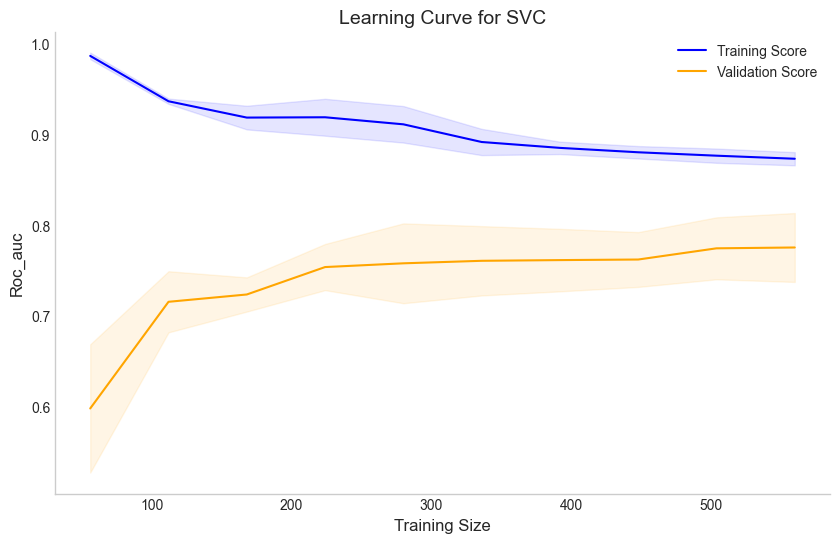

0.7649951409135083 ± 0.02587067180242917


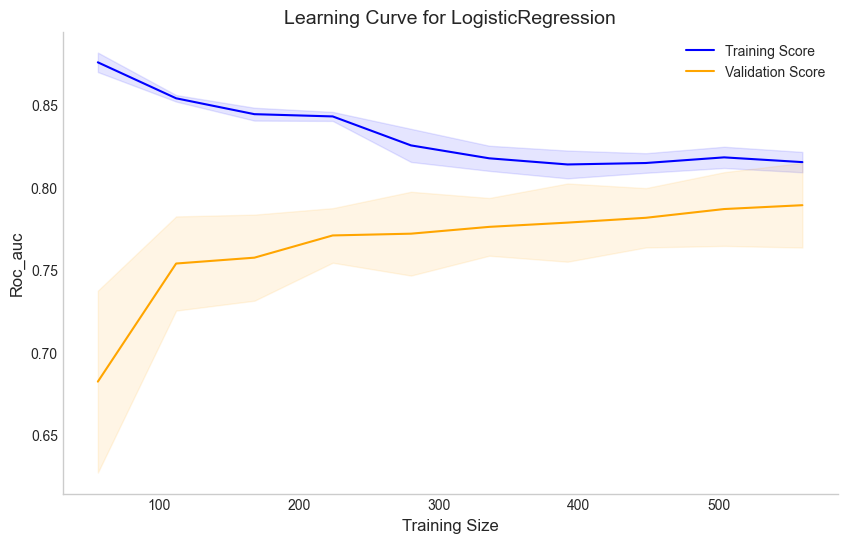

0.7576919339164236 ± 0.03412882845950027


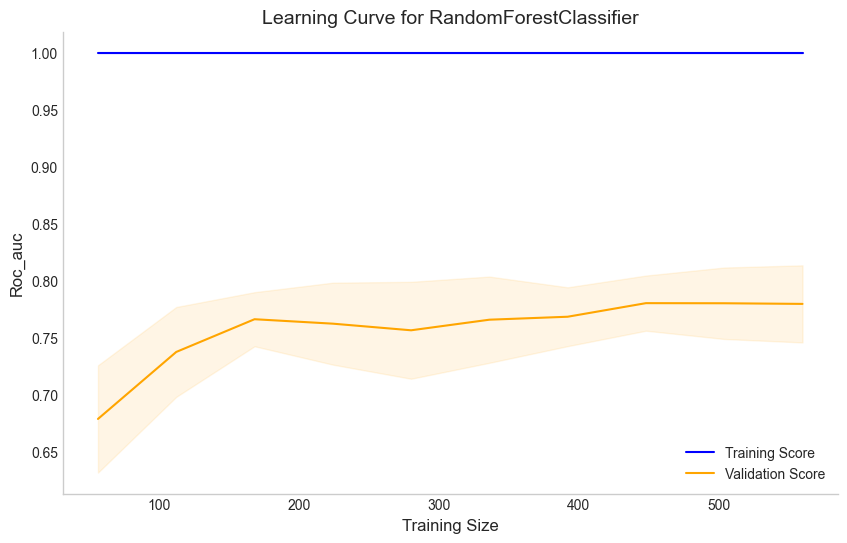

In [14]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


plot_learning_curve(SVC(random_state=RANDOM_STATE), train_df_svc, y_train)
plot_learning_curve(LogisticRegression(random_state=RANDOM_STATE), train_df_lrc, y_train)
plot_learning_curve(RandomForestClassifier(random_state=RANDOM_STATE), train_df_rfc, y_train)

<hr>

In [17]:
from scripts.functions import calculate_cost
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.metrics import make_scorer
from sklearn.svm import SVC

cost_scorer = make_scorer(calculate_cost, greater_is_better=False)
cost_tuned_model = TunedThresholdClassifierCV(SVC(random_state=RANDOM_STATE), scoring=cost_scorer, cv=10, store_cv_results=True)
cost_tuned_model.fit(train_df_svc, y_train)

Total cost : 105
Total cost : 100
Total cost : 100
Total cost : 100
Total cost : 100
Total cost : 100
Total cost : 100
Total cost : 100
Total cost : 100
Total cost : 100
Total cost : 100
Total cost : 100
Total cost : 100
Total cost : 100
Total cost : 100
Total cost : 100
Total cost : 95
Total cost : 95
Total cost : 95
Total cost : 95
Total cost : 90
Total cost : 90
Total cost : 90
Total cost : 90
Total cost : 90
Total cost : 85
Total cost : 85
Total cost : 85
Total cost : 85
Total cost : 85
Total cost : 85
Total cost : 85
Total cost : 85
Total cost : 85
Total cost : 86
Total cost : 86
Total cost : 86
Total cost : 81
Total cost : 81
Total cost : 82
Total cost : 82
Total cost : 72
Total cost : 74
Total cost : 74
Total cost : 64
Total cost : 64
Total cost : 64
Total cost : 64
Total cost : 66
Total cost : 64
Total cost : 64
Total cost : 65
Total cost : 65
Total cost : 65
Total cost : 66
Total cost : 61
Total cost : 61
Total cost : 63
Total cost : 63
Total cost : 65
Total cost : 61
Total co

,"estimator estimator: estimator instanceThe classifier, fitted or not, for which we want to optimizethe decision threshold used during `predict`.",SVC(random_state=8)
,"scoring scoring: str or callable, default=""balanced_accuracy""The objective metric to be optimized. Can be one of:- str: string associated to a scoring function for binary classification, see :ref:`scoring_string_names` for options.- callable: a scorer callable object (e.g., function) with signature ``scorer(estimator, X, y)``. See :ref:`scoring_callable` for details.",make_scorer(c...hod='predict')
,"response_method response_method: {""auto"", ""decision_function"", ""predict_proba""}, default=""auto""Methods by the classifier `estimator` corresponding to thedecision function for which we want to find a threshold. It can be:* if `""auto""`, it will try to invoke, for each classifier, `""predict_proba""` or `""decision_function""` in that order.* otherwise, one of `""predict_proba""` or `""decision_function""`. If the method is not implemented by the classifier, it will raise an error.",'auto'
,"thresholds thresholds: int or array-like, default=100The number of decision threshold to use when discretizing the output of theclassifier `method`. Pass an array-like to manually specify the thresholdsto use.",100
,"cv cv: int, float, cross-validation generator, iterable or ""prefit"", default=NoneDetermines the cross-validation splitting strategy to train classifier.Possible inputs for cv are:* `None`, to use the default 5-fold stratified K-fold cross validation;* An integer number, to specify the number of folds in a stratified k-fold;* A float number, to specify a single shuffle split. The floating number should be in (0, 1) and represent the size of the validation set;* An object to be used as a cross-validation generator;* An iterable yielding train, test splits;* `""prefit""`, to bypass the cross-validation.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... warning:: Using `cv=""prefit""` and passing the same dataset for fitting `estimator` and tuning the cut-off point is subject to undesired overfitting. You can refer to :ref:`TunedThresholdClassifierCV_no_cv` for an example. This option should only be used when the set used to fit `estimator` is different from the one used to tune the cut-off point (by calling :meth:`TunedThresholdClassifierCV.fit`).",10
,"refit refit: bool, default=TrueWhether or not to refit the classifier on the entire training set oncethe decision threshold has been found.Note that forcing `refit=False` on cross-validation having morethan a single split will raise an error. Similarly, `refit=True` inconjunction with `cv=""prefit""` will raise an error.",True
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel. When `cv` represents across-validation strategy, the fitting and scoring on each data splitis done in parallel. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of cross-validation when `cv` is a float.See :term:`Glossary `.",None
,"store_cv_results store_cv_results: bool, default=FalseWhether to store all scores and thresholds computed during the cross-validationprocess.",True
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that m

In [18]:


# Train sklearn-compatible models
from sklearn.model_selection import cross_val_score


for model in [SVC(random_state=RANDOM_STATE), LogisticRegression(random_state=RANDOM_STATE)]:
    for data in [train_df_svc, train_df_lrc]:
        print(f"\n{'─' * 40}")
        print(f"📊 Training: {model.__class__.__name__}")
        print(data.shape)
        print(f"{'─' * 40}")
        
        # Cross-validation for ROC-AUC
        roc_auc_scores = cross_val_score(model, data, y_train, cv=5, scoring='roc_auc')
        roc_auc_mean = np.mean(roc_auc_scores)
        roc_auc_std = np.std(roc_auc_scores)
        
        # Cross-validation for F1
        f1_scores = cross_val_score(model, data, y_train, cv=5, scoring='f1')
        f1_mean = np.mean(f1_scores)
        f1_std = np.std(f1_scores)
        
        print(f"   ROC-AUC:  {roc_auc_mean:.4f} ± {roc_auc_std:.4f}")
        print(f"   F1: {f1_mean:.4f} ± {f1_std:.4f}")

        
        # Fit model for learning curve
        model.fit(data, y_train)
        y_preds = model.predict(data)
        f1 = f1_score(y_train, y_preds)
        print(f"   F1 on training data: {f1:.4f}")
        precision = precision_score(y_train, y_preds)
        print(f"   Precision on training data: {precision:.4f}")
        
        # Plot learning curve
        #print(f"\n   📈 Learning Curve:")
        #plot_learning_curve(model, data, y_train, cv=5, scoring='roc_auc')


────────────────────────────────────────
📊 Training: SVC
(700, 25)
────────────────────────────────────────
   ROC-AUC:  0.7757 ± 0.0380
   F1: 0.8461 ± 0.0243
   F1 on training data: 0.8709
   Precision on training data: 0.8091

────────────────────────────────────────
📊 Training: SVC
(700, 22)
────────────────────────────────────────
   ROC-AUC:  0.7900 ± 0.0480
   F1: 0.8433 ± 0.0198
   F1 on training data: 0.8865
   Precision on training data: 0.8515

────────────────────────────────────────
📊 Training: LogisticRegression
(700, 25)
────────────────────────────────────────
   ROC-AUC:  0.7828 ± 0.0268
   F1: 0.8425 ± 0.0125
   F1 on training data: 0.8590
   Precision on training data: 0.8054

────────────────────────────────────────
📊 Training: LogisticRegression
(700, 22)
────────────────────────────────────────
   ROC-AUC:  0.7893 ± 0.0256
   F1: 0.8412 ± 0.0090
   F1 on training data: 0.8536
   Precision on training data: 0.8084


In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

svc_space = {
    'C': Real(0.1, 20, prior='uniform'),
    'gamma': Real(1e-4, 1, prior='uniform'),
    'kernel': Categorical(['rbf', 'linear']),
    'tol': Real(1e-4, 1e-1, prior='log-uniform'),
    'class_weight': Categorical(['balanced', None])
}


log_reg_space = {
    'penalty': Categorical(['l2']),
    'C': Real(0.01, 20, prior='log-uniform'),
    'solver': Categorical(['liblinear']),
    'max_iter': Integer(1000, 8000),
    'class_weight': Categorical(['balanced', None])
}

ran_forest_space = {
        'n_estimators': Integer(100, 500),
        'max_depth': Integer(5, 30),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 10),
        'max_features': Categorical(['sqrt', 'log2', None]),
    }

svc_tuned = BayesSearchCV(
    estimator=SVC(probability=True, random_state=RANDOM_STATE),
    search_spaces=svc_space,
    n_iter=20,
    scoring='roc_auc',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)
log_reg_tuned = BayesSearchCV(
    estimator=LogisticRegression(random_state=RANDOM_STATE),
    search_spaces=log_reg_space,
    n_iter=20,
    scoring='roc_auc',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

rfc_tuned = BayesSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE),
    search_spaces=ran_forest_space,
    n_iter=20,
    scoring='roc_auc',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

In [21]:
import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated")
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")
warnings.filterwarnings("ignore", category=FutureWarning)

for model, data in zip([svc_tuned, log_reg_tuned, rfc_tuned], [train_df_svc, train_df_lrc, train_df_rfc]):
            print(f"\n{'─' * 40}")
            print(f"🔍 Hyperparameter Tuning: {model.__class__.__name__}")
            print(data.shape)
            print(f"{'─' * 40}")
            model.fit(data, y_train)
            auc_scores = cross_val_score(model.best_estimator_, data, y_train, cv=10, scoring='roc_auc')
            print(f"{model.__class__.__name__} AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
            prec_scores = cross_val_score(model.best_estimator_, data, y_train, cv=10, scoring='precision')
            print(f"{model.__class__.__name__} Precision: {np.mean(prec_scores):.4f} ± {np.std(prec_scores):.4f}")
            f1_scores = cross_val_score(model.best_estimator_, data, y_train, cv=10, scoring='f1')
            print(f"{model.__class__.__name__} F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
            


────────────────────────────────────────
🔍 Hyperparameter Tuning: BayesSearchCV
(700, 25)
────────────────────────────────────────
BayesSearchCV AUC: 0.7897 ± 0.0615
BayesSearchCV Precision: 0.8583 ± 0.0530
BayesSearchCV F1: 0.7716 ± 0.0527

────────────────────────────────────────
🔍 Hyperparameter Tuning: BayesSearchCV
(700, 22)
────────────────────────────────────────
BayesSearchCV AUC: 0.7878 ± 0.0565
BayesSearchCV Precision: 0.8630 ± 0.0621
BayesSearchCV F1: 0.7820 ± 0.0606

────────────────────────────────────────
🔍 Hyperparameter Tuning: BayesSearchCV
(700, 35)
────────────────────────────────────────
BayesSearchCV AUC: 0.7932 ± 0.0573
BayesSearchCV Precision: 0.7604 ± 0.0234
BayesSearchCV F1: 0.8416 ± 0.0204



────────────────────────────────────────
SVC
   ROC-AUC:  0.8199
   Accuracy: 0.7600
   F1:       0.8144
   Precision:0.8876



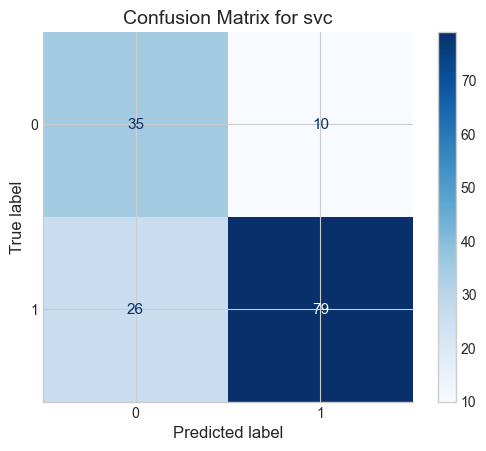

Total cost for svc: 76

────────────────────────────────────────
Logistic Regression
   ROC-AUC:  0.8116
   Accuracy: 0.7533
   F1:       0.8122
   Precision:0.8696



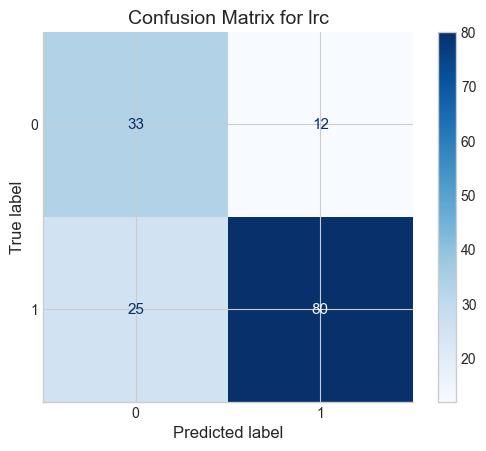

Total cost for lrc: 85

────────────────────────────────────────
Random Forest
   ROC-AUC:  0.7839
   Accuracy: 0.7667
   F1:       0.8523
   Precision:0.7652



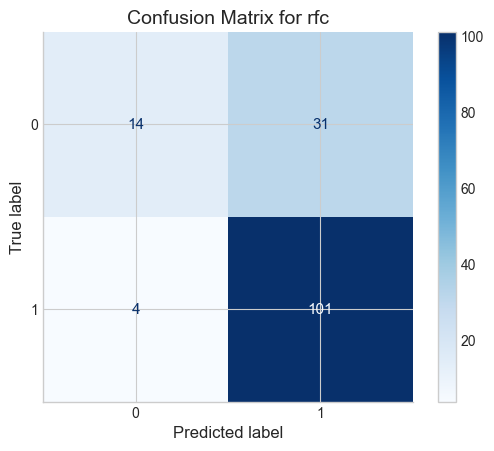

Total cost for rfc: 159


np.int64(159)

In [27]:
from sklearn.metrics import roc_auc_score, accuracy_score
import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated")
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

svc = svc_tuned.fit(train_df_svc, y_train)
log_reg = log_reg_tuned.fit(train_df_lrc, y_train)
rfc = rfc_tuned.fit(train_df_rfc, y_train)

val_df_svc = full_pipeline_svc.transform(X_val)
val_df_lrc = full_pipeline_lrc.transform(X_val)
val_df_rfc = full_pipeline_rfc.transform(X_val)


# Predict on validation set
y_pred = svc_tuned.best_estimator_.predict(val_df_svc)
y_pred_proba = svc_tuned.best_estimator_.predict_proba(val_df_svc)[:, 1]
        
# Calculate metrics
roc_auc = roc_auc_score(y_val, y_pred_proba)
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)

print(f"\n{'─' * 40}")
print('SVC')        
print(f"   ROC-AUC:  {roc_auc:.4f}")
print(f"   Accuracy: {accuracy:.4f}")
print(f"   F1:       {f1:.4f}")
print(f"   Precision:{precision:.4f}\n")
calculate_cost(y_val, y_pred, "svc", show_matrix=True)


print(f"\n{'─' * 40}")
print('Logistic Regression')    
# Predict on validation set
y_pred = log_reg_tuned.best_estimator_.predict(val_df_lrc)
y_pred_proba = log_reg_tuned.best_estimator_.predict_proba(val_df_lrc)[:, 1]
        
# Calculate metrics
roc_auc = roc_auc_score(y_val, y_pred_proba)
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
        
print(f"   ROC-AUC:  {roc_auc:.4f}")
print(f"   Accuracy: {accuracy:.4f}")
print(f"   F1:       {f1:.4f}")
print(f"   Precision:{precision:.4f}\n")
calculate_cost(y_val, y_pred, "lrc", show_matrix=True)

print(f"\n{'─' * 40}")
print('Random Forest')    
# Predict on validation set
y_pred = rfc_tuned.best_estimator_.predict(val_df_rfc)
y_pred_proba = rfc_tuned.best_estimator_.predict_proba(val_df_rfc)[:, 1]

        
# Calculate metrics
roc_auc = roc_auc_score(y_val, y_pred_proba)
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)

print(f"   ROC-AUC:  {roc_auc:.4f}")
print(f"   Accuracy: {accuracy:.4f}")
print(f"   F1:       {f1:.4f}")
print(f"   Precision:{precision:.4f}\n")   
calculate_cost(y_val, y_pred, "rfc", show_matrix=True)

In [ ]:
thresholds = np.arange(0.1, 0.9, 0.01)
accuracies = []
y_pred_proba = svc_tuned.predict_proba(val_df_svc)[:, 1]
for thresh in thresholds:
    y_pred = (y_pred_proba >= thresh).astype(int)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

In [ ]:
optimal_threshold = thresholds[np.argmax(accuracies)]
print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Best validation accuracy: {max(accuracies):.4f}")

Optimal threshold: 0.64
Best validation accuracy: 0.8067


0.56 for logreg with woe cols, 0.64 for svc with count cols

In [ ]:
train_df.columns

Index(['checking_account_status', 'credit_history', 'purpose',
       'savings_account_bonds', 'present_employment_since', 'property',
       'other_installment_plans', 'housing', 'job', 'monthly_burden_log',
       'duration_bins', 'credit_amount_bins', 'age_group'],
      dtype='object')

<hr>

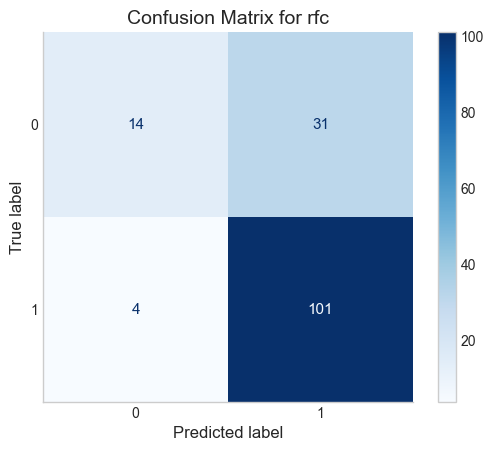

Total cost for rfc: 159


np.int64(159)

In [29]:
calculate_cost(y_val, y_pred, "rfc", show_matrix=True)

<hr>

from catboost import CatBoostClassifier

# Handle CatBoost separately
print(f"{'─' * 40}")
print(f"📊 Evaluating: CatBoost")
print(f"{'─' * 40}")

cat_features = [
    'checking_account_status', 'credit_history', 'purpose',
       'savings_account_bonds', 'present_employment_since', 'property',
       'other_installment_plans', 'housing', 'job',
       'duration_bins', 'credit_amount_bins', 'age_group'
]
catboost_val = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False, cat_features=cat_features)
catboost_val.fit(train_df, y_train)

val_df = FeatureEngineer().transform(X_val)
y_pred_cb = catboost_val.predict(val_df)
y_pred_proba_cb = catboost_val.predict_proba(val_df)[:, 1]

roc_auc_cb = roc_auc_score(y_val, y_pred_proba_cb)
accuracy_cb = accuracy_score(y_val, y_pred_cb)

print(f"   ROC-AUC:  {roc_auc_cb:.4f}")
print(f"   Accuracy: {accuracy_cb:.4f}\n")


In [26]:
import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated")
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")
warnings.filterwarnings("ignore", category=FutureWarning)


In [27]:
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

cat_features = [
    'checking_account_status', 'credit_history', 'purpose',
       'savings_account_bonds', 'present_employment_since', 'property',
       'other_installment_plans', 'housing', 'job',
       'duration_bins', 'credit_amount_bins', 'age_group'
]

lr_pipe = Pipeline([
    ('encoder', full_pipeline_lrc),
    ('classifier', log_reg_tuned.best_estimator_)
])

# Pipeline 3: SVC (needs WOE + scaling)
svc_pipe = Pipeline([
    ('encoder', full_pipeline_svc),
    ('classifier', svc_tuned.best_estimator_)
])

# Pipeline 4: Random Forest (needs One-Hot + scaling)
rfc_pipe = Pipeline([
    ('encoder', full_pipeline_rfc),
    ('classifier', rfc_tuned.best_estimator_)
])

ensemble = VotingClassifier(
    estimators=[
        ('catboost', rfc_pipe),
        ('lr', lr_pipe),
        ('svc', svc_pipe)
    ],
    voting='soft'  # Use probabilities
)

val_scores = cross_val_score(ensemble, X_train, y_train, cv=5, scoring='roc_auc')
print(f"cross_val_score: {np.mean(val_scores)} ± {np.std(val_scores)}")

print(f"\n{'─' * 40}")
print('Random Forest')    
# Predict on validation set
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_val)
y_pred_proba = ensemble.predict_proba(X_val)[:, 1]
        
# Calculate metrics
roc_auc = roc_auc_score(y_val, y_pred_proba)
accuracy = accuracy_score(y_val, y_pred)
        
print(f"   ROC-AUC:  {roc_auc:.4f}")
print(f"   Accuracy: {accuracy:.4f}\n")  

cross_val_score: 0.792128279883382 ± 0.025437491819710327

────────────────────────────────────────
Random Forest
   ROC-AUC:  0.8138
   Accuracy: 0.7467



0.7585034013605443 ± 0.027331849271517623


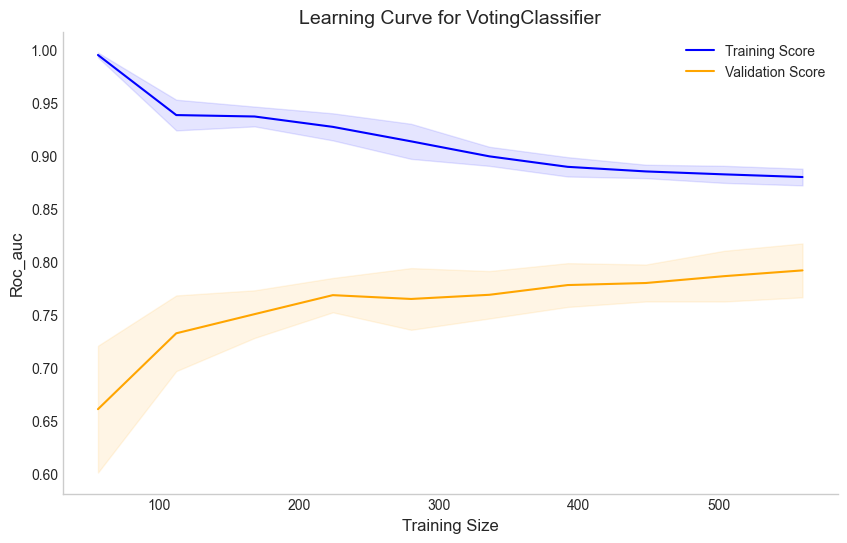

In [33]:
plot_learning_curve(ensemble, X_train, y_train)

In [29]:
plot_learning_curve(lrc_tuned.best_estimator_, train_df_lrc, y_train)

NameError: name 'lrc_tuned' is not defined

In [26]:
print(f"\n{'─' * 40}") 
# Predict on validation set
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_val)
y_pred_proba = ensemble.predict_proba(X_val)[:, 1]
        
# Calculate metrics
roc_auc = roc_auc_score(y_val, y_pred_proba)
accuracy = accuracy_score(y_val, y_pred)
        
print(f"   ROC-AUC:  {roc_auc:.4f}")
print(f"   Accuracy: {accuracy:.4f}\n")  


────────────────────────────────────────
Random Forest
   ROC-AUC:  0.8178
   Accuracy: 0.7467



In [28]:
thresholds = np.arange(0.1, 0.9, 0.01)
accuracies = []
y_pred_proba = ensemble.predict_proba(X_val)[:, 1]
for thresh in thresholds:
    y_pred = (y_pred_proba >= thresh).astype(int)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

In [29]:
optimal_threshold = thresholds[np.argmax(accuracies)]
print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Best validation accuracy: {max(accuracies):.4f}")

Optimal threshold: 0.61
Best validation accuracy: 0.7867


In [27]:
y_pred = ensemble.predict(X_test)
y_pred_proba = ensemble.predict_proba(X_test)[:, 1]
        
# Calculate metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
        
print(f"   ROC-AUC:  {roc_auc:.4f}")
print(f"   Accuracy: {accuracy:.4f}\n")  

   ROC-AUC:  0.8068
   Accuracy: 0.7667



In [30]:
plot_learning_curve(rfc_pipe, X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# ALWAYS track (essential):
essential_metrics = [
    'test_auc',              # Primary metric
    'test_precision',        # False positive rate
    'test_recall',           # False negative rate (critical for credit risk!)
    'test_f1',               # Balance metric
]

# RECOMMENDED track (valuable context):
recommended_metrics = [
    'train_auc',             # Check overfitting
    'train_test_gap',        # Overfitting magnitude
    'test_accuracy',         # For completeness (but don't optimize for it!)
    'cost_score',            # Business metric (5:1 cost ratio)
]

# CREDIT RISK specific:
credit_risk_metrics = [
    'ks_statistic',          # Kolmogorov-Smirnov (industry standard)
    'gini_coefficient',      # 2*AUC - 1
    'approval_rate',         # % predicted as good credit
    'bad_capture_rate',      # % of actual bads caught
]

# OPTIONAL track (nice to have):
optional_metrics = [
    'test_precision_at_80_recall',  # Precision when catching 80% of bads
    'test_recall_at_90_precision',  # Recall when 90% precision
    'expected_profit',               # If you have profit model
]

In [31]:
from imblearn.over_sampling import SVMSMOTE

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SVMSMOTE
X, y = make_classification(n_classes=2, class_sep=2,
weights=[0.2, 0.8], n_informative=3, n_redundant=1, flip_y=0,
n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
print('Original dataset shape %s' % Counter(y))
sm = SVMSMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({np.int64(1): 800, np.int64(0): 200})
Resampled dataset shape Counter({np.int64(0): 800, np.int64(1): 800})


In [33]:
X[999:], y[999:]

(array([[-0.29874435, -1.48144343, -0.34051766, -1.54721289,  1.46014183,
          2.75032985,  1.49194356, -0.50149386,  1.38985118,  2.15368725,
          1.82521552, -0.05597624, -1.02405471,  0.97861667, -0.93053419,
         -1.06921429,  1.17603601, -0.17772046, -0.13834763, -0.81195185]]),
 array([1]))

In [34]:
X_res[1000:1005], y_res[1000:1005]

(array([[ 0.08635087,  0.02512853, -1.65753764,  1.79928575,  0.77345807,
          2.43938756,  0.00780047,  0.24505242,  0.20733153, -0.47186135,
         -1.13405458,  0.09002113, -1.07114397, -0.94495748,  0.36372688,
          1.07314341,  1.80241877,  0.40399011, -0.98642062, -1.78767784],
        [-0.67084263, -1.37509082, -0.95831853,  0.67416043,  0.98125485,
          1.02920782, -0.14332824,  1.77086511,  1.02101137,  0.20331563,
         -0.85897008,  1.5058154 ,  0.30555886, -1.11637835,  0.46847267,
         -1.71322952, -2.26815056, -0.79409857,  1.48888208, -0.94142046],
        [ 1.33598449, -0.31775223,  1.0138267 , -0.50840822,  0.21634344,
          0.54551917, -0.50207459,  0.32818128, -0.72098953, -0.45598775,
         -1.74743675, -0.92926259, -1.11065508,  0.25560076,  0.19154842,
          0.26803095,  0.8599028 ,  0.55986022, -0.0277511 , -1.21546861],
        [ 2.0422047 , -0.63054659,  1.18638569,  0.40403544, -0.72067442,
          1.42213522, -0.17920055, 